In [1]:
# %load progress.py
"""PIV Algorithm
1) Process the images and gray scale them.
2) Loop through the images with interrogation windows.
3) For every window, compute the Fourier transforms.
4) Find the relative displacement in each position.
5) Compute the displacement vector by subtracting the peak position from the center position.
6) Return the displacement vector and plot the velocity field.
"""

import numpy as np
import scipy.fftpack as fft
import matplotlib.pyplot as plt
from PIL import Image


In [2]:
# Example usage with two images
#image_path = ['F_00001.bmp', 'F_00002.bmp']
image_path =['run1_000012.T000.D000.P000.H000.LA.TIF','run1_000012.T000.D000.P000.H000.LB.TIF']
image1 = Image.open(image_path[0]).convert('L')
image2 = Image.open(image_path[1]).convert('L')


In [3]:
def preprocess_image(image):
    """Convert image to numpy array and normalize."""
    return np.array(image) / 255.0

In [4]:
image1 = preprocess_image(image1)
image2 = preprocess_image(image2)

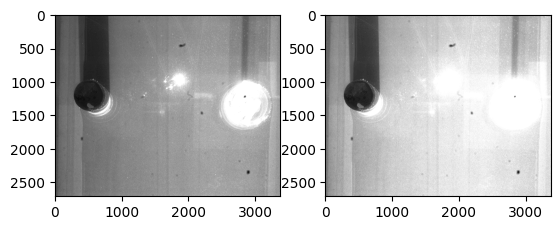

In [5]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image1, cmap='gray')
ax[1].imshow(image2, cmap='gray')
plt.show()

In [6]:
def cross_correlation_fft(window1, window2):
    """Compute cross-correlation using FFT."""
    f1 = fft.fft2(window1)  # FFT for window1
    f2 = fft.fft2(window2)  # FFT for window2
    f2_conj = np.conj(f2)  # Finding the conjugate of window2
    
    """When you apply FFT to an image, the zero frequency component ends up at the corners of the resulting array. This is because of how the FFT algorithm is implemented.
    High frequencies (rapid changes in intensity) are spread out across the array, with the lowest frequency (zero frequency) in the corners.
    fftshift moves the zero frequency component from the corners to the center of the array"""  
    #cross_corr=fft.ifft2(f1 * f2_conj)
    cross_corr = fft.fftshift(fft.ifft2(f1 * f2_conj))  # Multiplication in complex is convolution in spatial (correlation)
    cross_corr_abs = np.abs(cross_corr)  # Calculating the absolute value of the correlation
    width, height = cross_corr_abs.shape  # Initializing dimensions
    peak_x, peak_y = np.unravel_index(np.argmax(cross_corr_abs),
                                      cross_corr_abs.shape)  # Get indices where correlation function is maximum.
    dx = peak_x - (width // 2)  # Calculating displacement relative to the center
    dy = peak_y - (height // 2)  # Calculating displacement relative to the center
    """Note:
    Positive dx means a shift to the right.
    Negative dx means a shift to the left.
    Positive dy means a shift downward.
    Negative dy means a shift upward.
    """
    return dx, dy

In [7]:
window_size = 64
overlap = 0.5
# def compute_cross_function(image1, image2, window_size=32, overlap=0.5):
"""Compute velocity vectors from two images."""
#step = int(window_size * (1 - overlap))  # Calculate step size based on overlap
height, width = image1.shape  # Initialize array sizes
"""Initialize the displacement vectors"""

# x_displacement, y_displacement = compute_cross_function(image1, image2, window_size)  # Getting displacements array
step = window_size // 2  # Vector will be plotted every step
height, width = image1.shape  # Get the dimensions of the image
#print(height, width)
"""Only on X,Y values will the vectors be plotted"""
x_positions = np.arange(step, width, step) 
y_positions = np.arange(step, height, step)
#print("x_positions=", x_positions )
#print("y_positions=", y_positions )
X, Y = np.meshgrid(x_positions, y_positions)
U, V = np.zeros_like(X), np.zeros_like(Y) #U and V are new arrays of zeros, having the same shape and data type as X and Y, respectively.
#print(f"X shape: {X.shape}, Y shape: {Y.shape}, U shape: {U.shape}, V shape: {V.shape}")
#print(f"Expected number of vectors: {len(y_positions)}x{len(x_positions)}")

"""Iteration of both window 1 and 2 together with the assumption most of the particles didn’t exit the window"""
max_displacement = window_size//4  # Fliter bright spots
# Iterating over windows
for ci, i in enumerate(y_positions):
    for cj, j in enumerate(x_positions):
    
        # Extract windows
        window1 = image1[i:i + window_size, j:j + window_size]
        window2 = image2[i:i + window_size, j:j + window_size]

        # Compute displacement using cross-correlation
        dx, dy = cross_correlation_fft(window1, window2)

        # Filter out large displacements
        if np.abs(dx) > max_displacement or np.abs(dy) > max_displacement:
            dx, dy = 0, 0  # Set displacement to zero if too large

        # Store the filtered displacement
        U[ci, cj] = dx
        V[ci, cj] = dy
print("U (dx displacements):", U)
print("V (dy displacements):", V)        


U (dx displacements): [[ 1  1 -2 ...  0  0  1]
 [ 0  0 -1 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0 -1 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 2  0  0 ...  0  1 11]]
V (dy displacements): [[ 0  0 -1 ... -2 -2  0]
 [ 0  0 -2 ... -2 -2 -2]
 [ 1  0 -2 ... -2 -2 -1]
 ...
 [-3 -3 -3 ... -3 -3 -3]
 [-3 -3 -3 ... -3 -3 -3]
 [ 0  8 -3 ...  0 -2  1]]


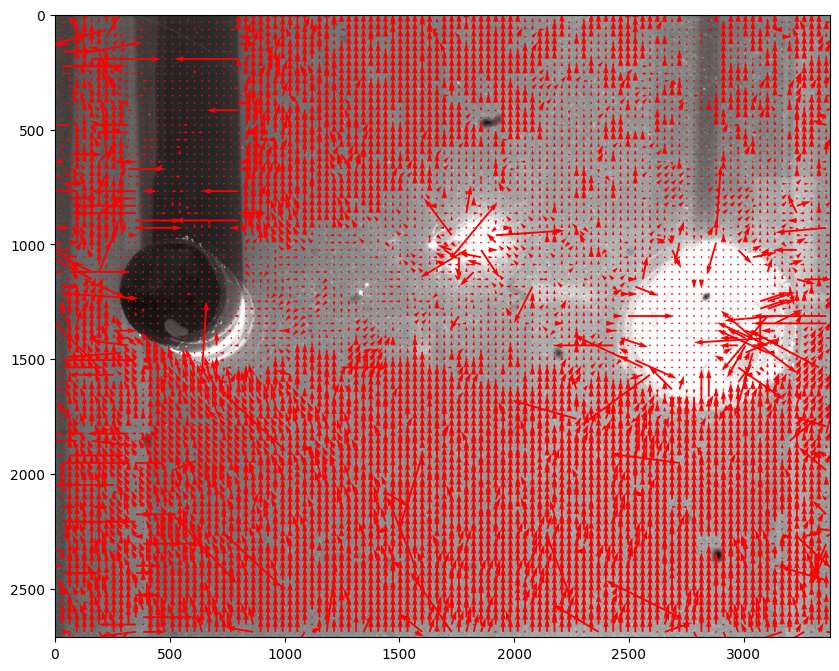

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(image1, cmap='gray')
plt.quiver(X, Y, U, V, color='r', angles='xy', scale_units='xy', scale=0.05)
